In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from models import glow
from flows.glow import resnet_glow
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
batch_size = 1
#X_train = np.expand_dims(X_train, axis=-1)
X_train_ds = tf.data.Dataset.from_tensor_slices(X_train.astype(np.float32))
X_train_ds = X_train_ds.map(lambda x: x / 255.).shuffle(buffer_size=1000).batch(batch_size)

In [3]:
#n_vars = np.prod(X_train.shape[1:])
#normal_diag = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros((1,n_vars,)), scale_diag=tf.ones((1,n_vars,)))
#reshape = tfp.bijectors.Reshape(X_train.shape[1:])
#prior = reshape(normal_diag)
prior = tfp.distributions.Normal(loc=tf.zeros((1, *X_train.shape[1:])), scale=tf.ones((1, *X_train.shape[1:])))
model = glow.Glow(prior, num_layers=3, depth_per_layer=8, coupling_nn_ctor=resnet_glow(hidden_dims=128),
                  optimizer=tf.keras.optimizers.Adamax(lr=1.0E-4))

In [4]:
from tqdm import tqdm
N = 1000
with tqdm(total=N) as prog:
    loss_hist = []
    nll_hist = []
    for batch in X_train_ds.take(N):
        loss, nll, ildj, grad_norm = model.train_batch(batch)
        loss_hist.append(loss.numpy())
        nll_hist.append(nll.numpy())
        prog.update(batch_size)
        prog.set_postfix({'loss': np.mean(loss_hist), 'nll': np.mean(nll_hist),
                          'ildj': ildj.numpy(),
                          'grad norm': grad_norm.numpy()})

  3%|▎         | 32/1000 [01:12<36:18,  2.25s/it, loss=2.37e+3, nll=2.36e+3, ildj=[[-1640.6368]], grad norm=3.02e+3] 


KeyboardInterrupt: 

In [5]:
x = model.target_dist.sample()
print(x)
print(tf.math.reduce_mean(model.target_dist.log_prob(x)))
_ = tf.debugging.assert_all_finite(x, 'found nan or inf values')

Instructions for updating:
Please use `layer.__call__` method instead.
tf.Tensor(
[[[[ 0.01323996  0.9813381   0.37864268]
   [ 1.7548782   0.7013017   1.818058  ]
   [-1.6204433  -0.03987405  1.8571427 ]
   ...
   [ 0.32715186  1.2992113  -1.2163656 ]
   [ 0.3035718  -0.6703576   1.6235622 ]
   [ 1.0174958   0.6501757  -0.9793401 ]]

  [[ 1.553085    1.6207334   0.02634368]
   [ 1.0947804  -0.27127197  1.3047345 ]
   [-0.31506982  2.184054    2.0495267 ]
   ...
   [-0.5204681  -1.471894   -1.4640329 ]
   [-0.1854706  -0.80934805 -0.87552357]
   [-0.5998923  -0.07327503 -0.9734777 ]]

  [[-0.4369815  -1.5359762   0.82488024]
   [ 0.3604944   0.49308258 -0.41630325]
   [ 0.24693291 -1.427611   -0.11485745]
   ...
   [ 0.27912644 -0.63975334 -0.39289424]
   [-0.10883448  1.3123494   0.2762793 ]
   [-0.9861782   0.1921412   1.3374366 ]]

  ...

  [[ 1.3142997   0.65974385  2.2629867 ]
   [-0.6165369  -0.75410897 -0.9254148 ]
   [ 0.31033128 -1.0828842   0.33278102]
   ...
   [ 0.31982476 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


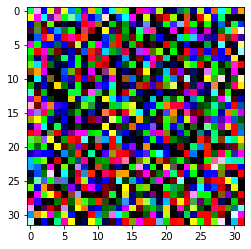

In [6]:
import matplotlib.pyplot as plt
plt.imshow(tf.squeeze(x))